In [1]:
import numpy as np
import pandas as pd
import transformers
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import RedditDataset
from model import SarcasmDetectionModel
from util import train_model, plot_loss, plot_accuracies, get_failed_examples, save_failed_examples

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Global Variables
device = "cuda" if torch.cuda.is_available() else "cpu"
reddit_dataset_dir = "train-balanced-sarcasm.csv"
split_ratio = 0.8
model_save_path = "model.pth"
loss_save_path = "losses.png"
acc_save_path = "accuracies.png"
failed_examples_save_path = "failed_examples.json"
seed = 25

# Hyperparameters
len_dataset = 6000
batch_size = 32
lr = 1e-5
n_epoch = 20

In [3]:
# Load the data and shuffle it
print("Loading data...")
df = pd.read_csv(reddit_dataset_dir)
# Sample 3000 rows from each class for the training dataset
sarcasm_sample = df[df["label"] == 1].sample(n=len_dataset//2, random_state=seed)
regular_sample = df[df["label"] == 0].sample(n=len_dataset//2, random_state=seed)
# Combine the sampled training data
reddit_dataset = pd.concat([sarcasm_sample, regular_sample])
print(f"Instances of each sample in the entire dataset: {reddit_dataset['label'].value_counts()}")

Loading data...
Instances of each sample in the entire dataset: label
1    3000
0    3000
Name: count, dtype: int64


In [4]:
reddit_dataset["context_comment"] = reddit_dataset.apply(lambda row: f"Context: {row['parent_comment']}; Comment: {row['comment']}", axis=1)
reddit_dataset["subreddit_comment"] = reddit_dataset.apply(lambda row: f"Subreddit: {row['subreddit']}; Comment: {row['comment']}", axis=1)
reddit_dataset["context_subreddit_comment"] = reddit_dataset.apply(lambda row: f"Context: {row['parent_comment']}; Subreddit: {row['subreddit']}; Comment: {row['comment']}", axis=1)
reddit_dataset = reddit_dataset.sample(frac=1, random_state=seed).reset_index(drop=True)

In [5]:
# Load the pre-trained BERT model
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, "bert-base-uncased")
# model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, "distilbert-base-uncased")

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

# Part 1 - Comment only

In [6]:
# Tokenize the dataset
tokenized_dataset_reddit = reddit_dataset["comment"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

# Padding to match the shapes of all the input data
max_len = 0
for i in tokenized_dataset_reddit.values:
    if len(i) > max_len:
        max_len = len(i)

padded_dataset_reddit = np.array([i + [0]*(max_len-len(i)) for i in tokenized_dataset_reddit.values])
print(f"Shape of the padded dataset: {np.array(padded_dataset_reddit).shape}")

Shape of the padded dataset: (6000, 191)


In [7]:
# Add a mask so that the model doesn't consider padded tokens
attention_mask_reddit = np.where(padded_dataset_reddit != 0, 1, 0)
print(f"Shape of the masked dataset: {attention_mask_reddit.shape}")

Shape of the masked dataset: (6000, 191)


In [8]:
# Split the data in training and testing sets and create dataloaders
split_val = int(split_ratio*len_dataset)
print(f"Splitting the data -> Train ({split_val}) & Test ({len_dataset-split_val})")

train_features_reddit = torch.tensor(padded_dataset_reddit[:split_val], device=device).long()
train_mask_reddit = torch.tensor(attention_mask_reddit[:split_val], device=device).long()
train_labels_reddit = torch.tensor(reddit_dataset["label"].values[:split_val], device=device).long()
train_dataset_reddit = RedditDataset(train_features_reddit, train_mask_reddit, train_labels_reddit)
train_loader_reddit = DataLoader(train_dataset_reddit, batch_size=batch_size, shuffle=True)

test_features_reddit = torch.tensor(padded_dataset_reddit[split_val:], device=device).long()
test_mask_reddit = torch.tensor(attention_mask_reddit[split_val:], device=device).long()
test_labels_reddit = torch.tensor(reddit_dataset["label"].values[split_val:], device=device).long()
test_dataset_reddit = RedditDataset(test_features_reddit, test_mask_reddit, test_labels_reddit)
test_loader_reddit = DataLoader(test_dataset_reddit, batch_size=batch_size)

print(f"Instances of each sample in the train set: {reddit_dataset[:split_val]['label'].value_counts()}")
print(f"Instances of each sample in the test set: {reddit_dataset[split_val:]['label'].value_counts()}")

Splitting the data -> Train (4800) & Test (1200)
Instances of each sample in the train set: label
1    2413
0    2387
Name: count, dtype: int64
Instances of each sample in the test set: label
0    613
1    587
Name: count, dtype: int64


In [9]:
# Define the model, optimizer and the loss function
model = SarcasmDetectionModel(bert_model).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

In [10]:
# Create arrays to document progress
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [11]:
# Train and Evaluate the model
for epoch in range(n_epoch):
    train_loss, train_acc, test_loss, test_acc = train_model(model, optimizer, loss_function, train_loader_reddit, len(train_labels_reddit), test_loader_reddit, len(test_labels_reddit), epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

Epoch 0 -> Train loss: 0.6971 Train acc: 53.56% Test acc: 60.17%
Epoch 1 -> Train loss: 0.6529 Train acc: 61.17% Test acc: 61.92%
Epoch 2 -> Train loss: 0.6126 Train acc: 66.06% Test acc: 64.17%
Epoch 3 -> Train loss: 0.5779 Train acc: 70.29% Test acc: 66.08%
Epoch 4 -> Train loss: 0.5442 Train acc: 71.92% Test acc: 65.58%
Epoch 5 -> Train loss: 0.5121 Train acc: 74.96% Test acc: 66.50%
Epoch 6 -> Train loss: 0.4756 Train acc: 76.92% Test acc: 66.75%
Epoch 7 -> Train loss: 0.4416 Train acc: 79.21% Test acc: 66.33%
Epoch 8 -> Train loss: 0.4017 Train acc: 82.29% Test acc: 67.08%
Epoch 9 -> Train loss: 0.3534 Train acc: 85.08% Test acc: 65.50%
Epoch 10 -> Train loss: 0.3211 Train acc: 86.44% Test acc: 65.67%
Epoch 11 -> Train loss: 0.2723 Train acc: 88.94% Test acc: 65.33%
Epoch 12 -> Train loss: 0.2334 Train acc: 91.15% Test acc: 65.42%
Epoch 13 -> Train loss: 0.1930 Train acc: 92.85% Test acc: 66.33%
Epoch 14 -> Train loss: 0.1547 Train acc: 94.75% Test acc: 65.67%
Epoch 15 -> Train lo

In [12]:
# Save the model
torch.save(model.state_dict(), model_save_path)

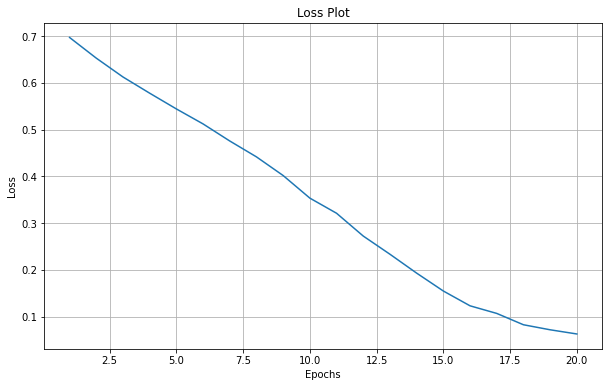

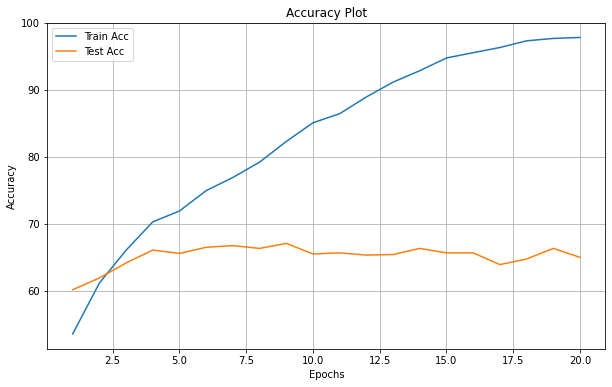

In [13]:
# Plot the results
plot_loss(train_losses, "Loss Plot", "Train Loss", "Loss", loss_save_path)
plot_accuracies(train_accuracies, test_accuracies, "Accuracy Plot", "Train Acc", "Test Acc", "Accuracy", acc_save_path)

In [14]:
# Get failed examples
failed_examples = get_failed_examples(model, test_loader_reddit, tokenizer)
save_failed_examples(failed_examples, failed_examples_save_path)

2024-06-05 08:16:48.305998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
